In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time
import csv
from astropy.io import ascii
import pandas as pd
import pickle

import os
Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline


## Core code / functions

#### 2D plot Code

In [109]:
def plot_continuum_tau(hdulist_hi, ra_deg, dec_deg, tau):
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header

    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection=WCS(h))
    
    # Display the moment map image
    im = ax.imshow(d, cmap='plasma', vmax=np.percentile(d,99.9))
    
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    
    im2 = ax.scatter(ra_deg, dec_deg, transform=ax.get_transform('fk5'), \
                     marker='o', s=100, linewidth=1.5, edgecolor='k', c=tau, \
                     cmap='gray_r', vmin=0, vmax=np.max(tau), alpha=0.8)
    
    #ax.set_title('Hydra', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
    ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)
    
    cbar_hi = plt.colorbar(im, orientation='vertical', fraction=0.022, pad=0.12)
    cbar_hi.set_label('N(HI)', size=18)
    cbar_hi2 = plt.colorbar(im2, orientation='vertical', fraction=0.02, pad=0.12)
    cbar_hi2.set_label(r'$\tau$', size=18)
    
    overlay = ax.get_coords_overlay('galactic')
    overlay.grid(color='k', ls='dotted')
    overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
    overlay[1].set_axislabel('Galactic Latitude', fontsize=22)
    overlay[0].tick_params(axis='both', which='major', labelsize=18)
    overlay[1].tick_params(axis='both', which='major', labelsize=18)
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

#### 3D plot Code

In [81]:
from mpl_toolkits.mplot3d import Axes3D
from astropy.wcs import WCS

def plot_continuum_tau_3d(hdulist_hi, ra_deg, dec_deg, tau, elev=30, azim=-30):
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header
    
    # Create a figure with 3D projection
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Set up WCS for 2D projection of the moment map
    wcs_2d = WCS(h)
    x_idx, y_idx = np.meshgrid(np.arange(d.shape[1]), np.arange(d.shape[0]))
    
    # Use the Z plane as 0 for the moment map image
    ax.plot_surface(x_idx, y_idx, np.zeros_like(d), rstride=1, cstride=1, facecolors=plt.cm.plasma(d / np.nanmax(d)), shade=False)

    # Convert RA/Dec to pixel coordinates using WCS
    ra_pix, dec_pix = wcs_2d.wcs_world2pix(ra_deg, dec_deg, 1)
    
    # Plot 3D bars for scatter points, using tau as the height (z-axis)
    ax.bar3d(ra_pix, dec_pix, np.zeros_like(tau), dx=5, dy=5, dz=tau, color=plt.cm.gray_r(tau / np.nanmax(tau)), alpha=0.9)

    # Set axis labels
    ax.set_xlabel('RA', fontsize=14)
    ax.set_ylabel('Dec', fontsize=14)
    ax.set_zlabel(r'$\tau$', fontsize=14)
    
    # Set limits
    ax.set_xlim([0, d.shape[1]])
    ax.set_ylim([0, d.shape[0]])
    
    # Perspective view: adjust the elevation and azimuth for a better 3D view
    ax.view_init(elev=elev, azim=azim)  # Change these values for different perspectives

        # Adjust the spacing between the plot and the colorbars to avoid overlap
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)  # Adjust these values to control the spacing
    
    
    # Add colorbars
    mappable_d = plt.cm.ScalarMappable(cmap='RdBu_r')
    mappable_d.set_array(d)
    fig.colorbar(mappable_d, ax=ax, shrink=0.6, pad=0.15, label='N(HI)')

    mappable_tau = plt.cm.ScalarMappable(cmap='inferno')
    mappable_tau.set_array(tau)
    fig.colorbar(mappable_tau, ax=ax, location='left', shrink=0.6, label=r'$\tau$')
    
    plt.show()



# ATCA

### Getting the coordinates

In [4]:
sources_h = pd.read_csv(f'ATCA_HI_spectra/hydra_coords.csv', index_col=0)
ra_h = np.array(sources_h['ra (hms)'])
dec_h = np.array(sources_h['dec (dms)'])
ra_deg_h = np.array(sources_h['ra (deg)'])
dec_deg_h = np.array(sources_h['dec (deg)'])
centre_h = '10:29:00, -27:35:25'
coordinate_h = centre_h.replace(',', '')
c_h = SkyCoord(coordinate_h, unit=(u.hourangle, u.deg))
path_hi_h = SkyView.get_images(position=centre_h, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
hdulist_hi_h = path_hi_h[0]

sources_n = pd.read_csv(f'ATCA_HI_spectra/norma_coords.csv', index_col=0)
ra_n = np.array(sources_n['ra (hms)'])
dec_n = np.array(sources_n['dec (dms)'])
ra_deg_n = np.array(sources_n['ra (deg)'])
dec_deg_n = np.array(sources_n['dec (deg)'])
centre_n = '16:38:00, -59:50:00'
coordinate_n = centre_n.replace(',', '')
c_n = SkyCoord(coordinate_n, unit=(u.hourangle, u.deg))
path_hi_n = SkyView.get_images(position=centre_n, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
hdulist_hi_n = path_hi_n[0]


In [5]:
with open('Decomposition/ATCA/sources_4k_norma.pkl', 'rb') as f:
    dict_4k_n = pickle.load(f)
with open('Decomposition/ATCA/sources_4k1_hydra.pkl', 'rb') as f:
    dict_4k1_h = pickle.load(f)
with open('Decomposition/ATCA/sources_4k2_hydra.pkl', 'rb') as f:
    dict_4k2_h = pickle.load(f)

In [6]:
with open('Decomposition/ATCA/sources_v21000_norma.pkl', 'rb') as f:
    dict_v21000_n = pickle.load(f)
with open('Decomposition/ATCA/sources_v210001_hydra.pkl', 'rb') as f:
    dict_v210001_h = pickle.load(f)
with open('Decomposition/ATCA/sources_v210002_hydra.pkl', 'rb') as f:
    dict_v210002_h = pickle.load(f)

In [7]:
with open('Decomposition/ATCA/sources_v21500_hydra.pkl', 'rb') as f:
    dict_v21500_h = pickle.load(f)
with open('Decomposition/ATCA/sources_v21500_norma.pkl', 'rb') as f:
    dict_v21500_n = pickle.load(f)


In [8]:
with open('gausspyplus/ATCA/decomposition_hydra4k1/gpy_decomposed/spectra_4k1_g+_fit_fin.pickle', 'rb') as f:
    decomposition_hydra4k1 = pickle.load(f)

with open('gausspyplus/ATCA/decomposition_hydra4k2/gpy_decomposed/spectra_4k2_g+_fit_fin.pickle', 'rb') as f:
    decomposition_hydra4k2 = pickle.load(f)

with open('gausspyplus/ATCA/decomposition_hydraV210001/gpy_decomposed/spectra_v2-10001_g+_fit_fin.pickle', 'rb') as f:
    decomposition_hydraV210001 = pickle.load(f)

with open('gausspyplus/ATCA/decomposition_hydraV210002/gpy_decomposed/spectra_v2-10002_g+_fit_fin.pickle', 'rb') as f:
    decomposition_hydraV210002 = pickle.load(f)

with open('gausspyplus/ATCA/decomposition_hydraV21500/gpy_decomposed/spectra_v2-1500_g+_fit_fin.pickle', 'rb') as f:
    decomposition_hydraV21500 = pickle.load(f)

In [9]:
with open('gausspyplus/ATCA/decomposition_norma4k/gpy_decomposed/spectra_4k_g+_fit_fin.pickle', 'rb') as f:
    decomposition_norma4k = pickle.load(f)

with open('gausspyplus/ATCA/decomposition_normaV21000/gpy_decomposed/spectra_v2-1000_g+_fit_fin.pickle', 'rb') as f:
    decomposition_normaV21000 = pickle.load(f)

with open('gausspyplus/ATCA/decomposition_normaV21500/gpy_decomposed/spectra_v2-1500_g+_fit_fin.pickle', 'rb') as f:
    decomposition_normaV21500 = pickle.load(f)

In [10]:
def get_name_amplitudes(dictionary, decomposition):
    # Create a mapping from index to name
    index_to_name = {data['index']: name for name, data in dictionary.items()}

    # Iterate over indices and amplitudes
    result = []
    for idx, amplitudes in zip(decomposition['index_fit'], decomposition['amplitudes_fit']):
        name = index_to_name.get(idx)
        result.append((name, amplitudes))
    return result


In [11]:
result_4k1_h = get_name_amplitudes(dict_4k1_h, decomposition_hydra4k1)
result_4k2_h = get_name_amplitudes(dict_4k2_h, decomposition_hydra4k2)
result_4k_n = get_name_amplitudes(dict_4k_n, decomposition_norma4k)

result_v210001_h = get_name_amplitudes(dict_v210001_h, decomposition_hydraV210001)
result_v210002_h = get_name_amplitudes(dict_v210002_h, decomposition_hydraV210002)
result_v21000_n = get_name_amplitudes(dict_v21000_n, decomposition_normaV21000)

result_v21500_h = get_name_amplitudes(dict_v21500_h, decomposition_hydraV21500)
result_v21500_n = get_name_amplitudes(dict_v21500_n, decomposition_normaV21500)



In [12]:
# Combine all results ending with '_h' into one list
all_results_h = (
    result_4k1_h +
    result_4k2_h +
    result_v210001_h +
    result_v210002_h +
    result_v21500_h
)

In [13]:
# Create a dictionary mapping names to amplitudes
name_to_amplitudes_h = {}
for name, amplitudes in all_results_h:
    # If there are multiple entries for the same name, you might want to handle duplicates
    name_to_amplitudes_h[name] = amplitudes


In [14]:
# Ensure that 'name' is the column in sources_h that matches the names in your results
sources_h['amplitudes'] = sources_h['source'].map(name_to_amplitudes_h)

In [15]:
# Combine all results ending with '_h' into one list
all_results_n = (
    result_4k_n +
    result_v21000_n +
    result_v21500_n
)

In [16]:
# Create a dictionary mapping names to amplitudes
name_to_amplitudes_n = {}
for name, amplitudes in all_results_n:
    # If there are multiple entries for the same name, you might want to handle duplicates
    name_to_amplitudes_n[name] = amplitudes


In [17]:
# Ensure that 'name' is the column in sources_h that matches the names in your results
sources_n['amplitudes'] = sources_n['source'].map(name_to_amplitudes_n)

In [18]:
# Function to get the maximum value of a list
def get_max_value(lst):
    if lst == None:
        return 0
    else:
        return max(lst)

In [19]:
# Function to extract the maximum amplitude from the amplitudes list
def get_max_amplitude(amplitudes):
    if isinstance(amplitudes, list) and amplitudes:
        return max(amplitudes)
    else:
        return None  # or np.nan if you prefer

In [20]:
# Apply the function to the 'amplitudes' column to create 'max_amplitude'
sources_h['max_amplitude'] = sources_h['amplitudes'].apply(get_max_amplitude)
sources_n['max_amplitude'] = sources_n['amplitudes'].apply(get_max_amplitude)

In [21]:
sources_n.head()

,source,ra (deg),dec (deg),ra (hms),dec (dms),amplitudes,max_amplitude
0,j171029-6041,257.620833,-60.688056,17:10:28.99999464,-60:41:16.99998396,"[0.715140567938906, 0.2930545150341325, 0.0550...",0.715141
1,j163405-5908,248.520833,-59.137500,16:34:04.99999368,-59:08:14.99991792,[],NaN
2,j162909-6133,247.288333,-61.562500,16:29:09.19999392,-61:33:45.00004968,"[0.29869517158469117, 0.26727420387932305]",0.298695
3,j161257-5737,243.237500,-57.619444,16:12:56.99999568,-57:37:10.00005672,"[2.0441341732952107, 0.9421603640044148]",2.044134
5,j161717-5848,244.320833,-58.802500,16:17:17.0000016,-58:48:08.99991684,[0.7079154507166171],0.707915


## Hydra

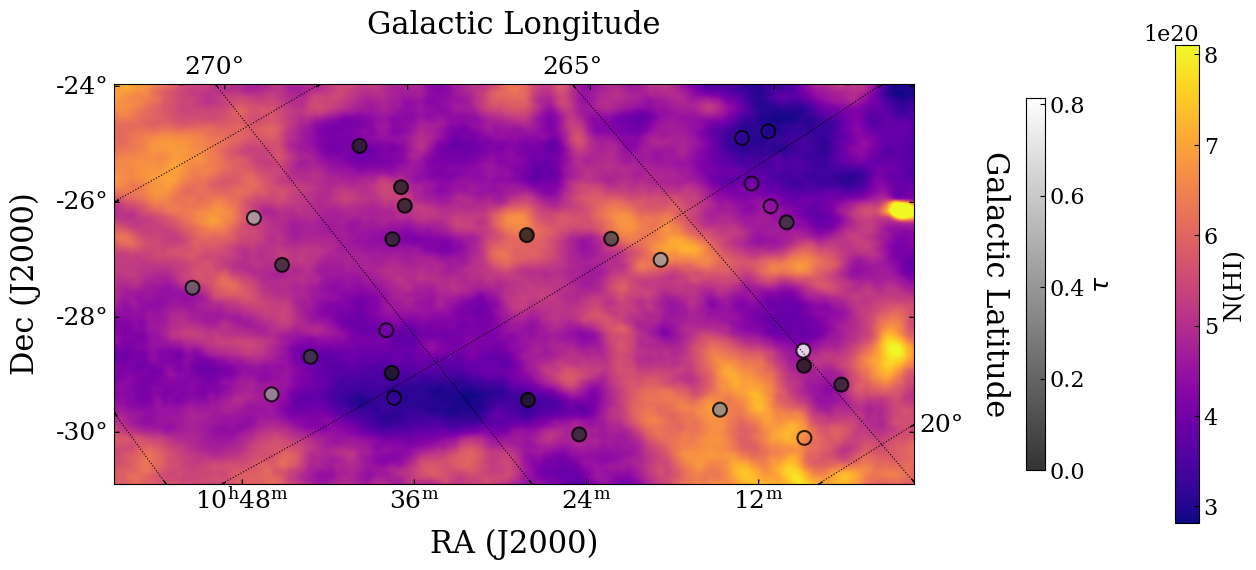

In [51]:
plot_continuum_tau(hdulist_hi_h, ra_deg_h, dec_deg_h, sources_h['max_amplitude'])

In [54]:
# Replace NaN values in the 'max_amplitude' array with 0
sources_h['max_amplitude'] = np.nan_to_num(sources_h['max_amplitude'], nan=0.0)

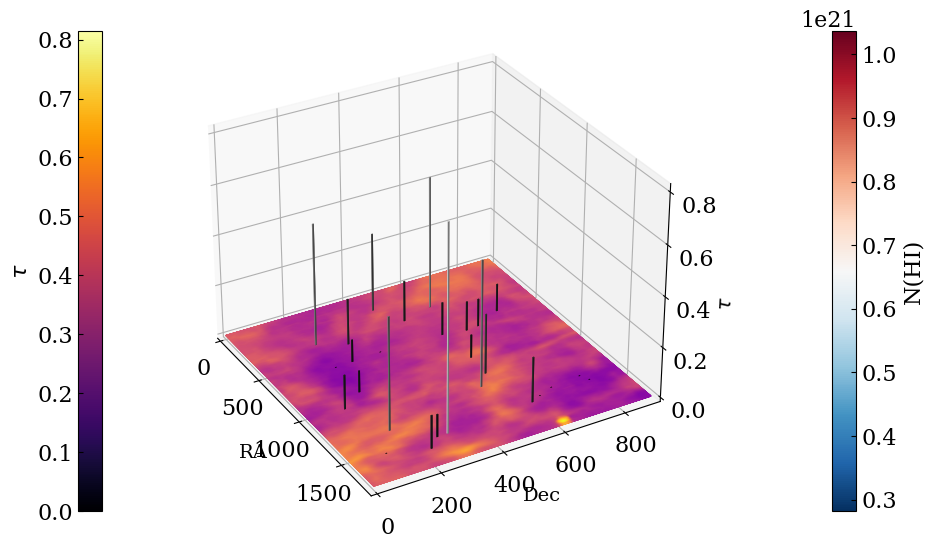

In [56]:
plot_continuum_tau_3d(hdulist_hi_h, ra_deg_h, dec_deg_h, sources_h['max_amplitude'])

## Norma

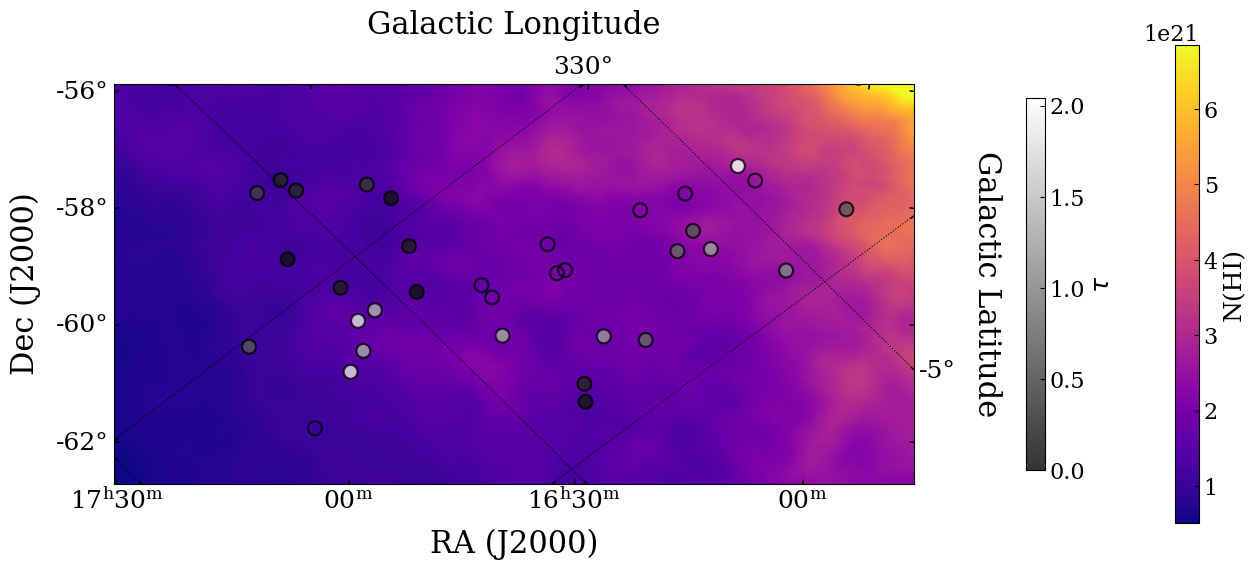

In [57]:
plot_continuum_tau(hdulist_hi_n, ra_deg_n, dec_deg_n, sources_n['max_amplitude'])

In [58]:
# Replace NaN values in the 'max_amplitude' array with 0
sources_n['max_amplitude'] = np.nan_to_num(sources_n['max_amplitude'], nan=0.0)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (297,) and arg 2 with shape (34,).

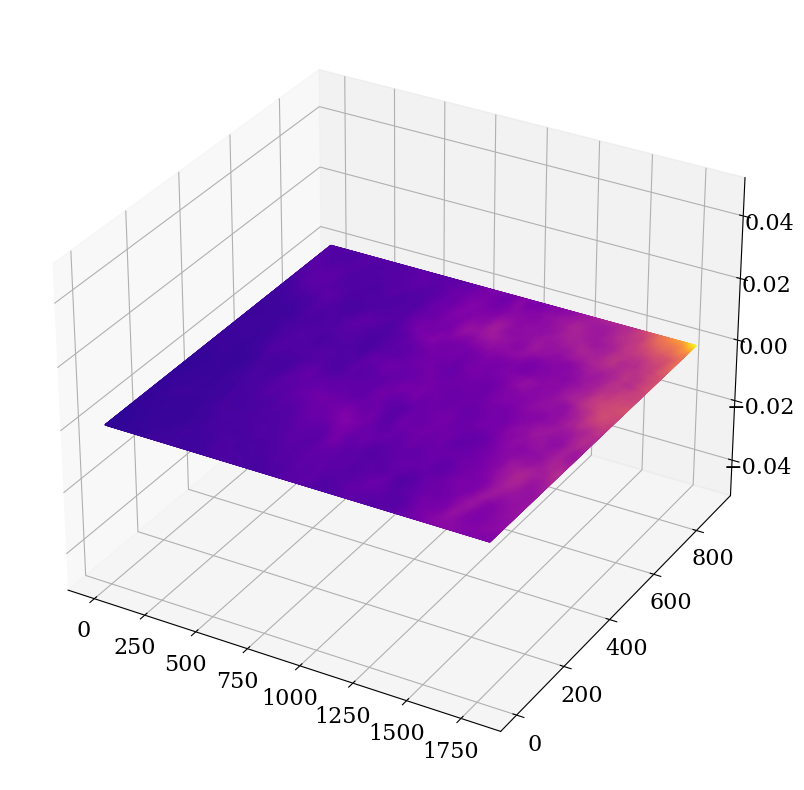

In [83]:
plot_continuum_tau_3d(hdulist_hi_n, ra_deg_n, dec_deg_n, sources_n['max_amplitude'], elev=40, azim=-90)

# ASKAP

### Getting coordinates

In [62]:
# Assuming the 'ASKAP_spectra/Hydra/' directory path
directory_path_hydra = 'ASKAP_spectra/Hydra/'
directory_path_norma = 'ASKAP_spectra/Norma/'

# List all filenames in the directory
filenames_hydra = [f for f in os.listdir(directory_path_hydra) if f.endswith('_askap_spectrum.txt')]
filenames_norma = [f for f in os.listdir(directory_path_norma) if f.endswith('_askap_spectrum.txt')]

# Function to convert RA in HMS to degrees
def ra_hms_to_deg(h, m, s):
    return 15 * (int(h) + int(m)/60 + float(s)/3600)

# Function to convert Dec in DMS to degrees
def dec_dms_to_deg(sign, d, m, s):
    dec_deg = int(d) + int(m)/60 + float(s)/3600
    return -dec_deg if sign == '-' else dec_deg

# Function to extract the source, RA, and Dec from the filename
def extract_coordinates(filename):
    # Extract the RA and Dec from the filename
    name = filename.split('_')[0]
    
    # Source name (optional)
    source = name[:15]  # first 6 characters as example source
    
    # Right Ascension (RA)
    ra_hours = name[:2]
    ra_minutes = name[2:4]
    ra_seconds = name[4:8]
    ra_hms = f"{ra_hours}:{ra_minutes}:{ra_seconds}"
    ra_deg = ra_hms_to_deg(ra_hours, ra_minutes, ra_seconds)
    
    # Declination (Dec)
    sign = name[8]
    dec_degrees = name[9:11]
    dec_arcminutes = name[11:13]
    dec_arcseconds = name[13:15]
    dec_dms = f"{sign}{dec_degrees}:{dec_arcminutes}:{dec_arcseconds}"
    dec_deg = dec_dms_to_deg(sign, dec_degrees, dec_arcminutes, dec_arcseconds)
    
    return source, ra_deg, dec_deg, ra_hms, dec_dms


### Coordinates in a Df

In [63]:
# Create a list of tuples with source, RA in deg, Dec in deg, RA in HMS, Dec in DMS
coordinates_hydra = [extract_coordinates(filename) for filename in filenames_hydra]
coordinates_norma = [extract_coordinates(filename) for filename in filenames_norma]


# Create the DataFrame with the desired columns
df_hydra = pd.DataFrame(coordinates_hydra, columns=['source', 'ra (deg)', 'dec (deg)', 'ra (hms)', 'dec (dms)'])
df_norma = pd.DataFrame(coordinates_norma, columns=['source', 'ra (deg)', 'dec (deg)', 'ra (hms)', 'dec (dms)'])

## Hydra

In [64]:
with open('gausspyplus/ASKAP/decomposition_hydra/gpy_decomposed/spectra_hydra_g+_fit_fin.pickle', 'rb') as f:
    decomposition_hydra = pickle.load(f)

In [65]:
# decomposition_hydra.keys()

In [66]:
with open('Decomposition/ASKAP/coordinates_hydra.pkl', 'rb') as f:
    location_hydra = pickle.load(f)

In [68]:
def get_amplitudes_hydra(source):
    # Get the index_fit corresponding to the source from location_hydra
    index_fit = location_hydra.get(source,{}).get('index',None)
    
    # If the index_fit exists, get the corresponding amplitudes from decomposition_hydra
    if index_fit != None:
        return decomposition_hydra.get('amplitudes_fit', None)[index_fit]
    return None

# Apply the function to the 'source' column of df_hydra and create a new column 'amplitudes_fit'
df_hydra['amplitudes_fit'] = df_hydra['source'].apply(get_amplitudes_hydra)

In [69]:
df_hydra['max_amp'] = df_hydra['amplitudes_fit'].apply(lambda x: max(x) if isinstance(x, list) and len(x) > 0 else None)

In [70]:
df_hydra.head()

,source,ra (deg),dec (deg),ra (hms),dec (dms),amplitudes_fit,max_amp
0,102809.8-264418,157.040833,-26.738333,10:28:09.8,-26:44:18,"[0.05386181535829614, 0.010638991660644187]",0.053862
1,101105.5-284740,152.772917,-28.794444,10:11:05.5,-28:47:40,[0.04031848132195306],0.040318
2,103723.8-290754,159.349167,-29.131667,10:37:23.8,-29:07:54,"[0.017851521503968498, 0.00579358794049689]",0.017852
3,105042.4-273309,162.676667,-27.552500,10:50:42.4,-27:33:09,[0.09875398504759623],0.098754
4,104749.8-273253,161.957500,-27.548056,10:47:49.8,-27:32:53,[0.15450326965502972],0.154503


In [71]:
ra_h = np.array(df_hydra['ra (hms)'])
dec_h = np.array(df_hydra['dec (dms)'])
ra_deg_h = np.array(df_hydra['ra (deg)'])
dec_deg_h = np.array(df_hydra['dec (deg)'])
centre_h = '10:29:00, -27:35:25'
coordinate_h = centre_h.replace(',', '')
c_h = SkyCoord(coordinate_h, unit=(u.hourangle, u.deg))
path_hi_h = SkyView.get_images(position=centre_h, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
hdulist_hi_h = path_hi_h[0]

#### 2D plot

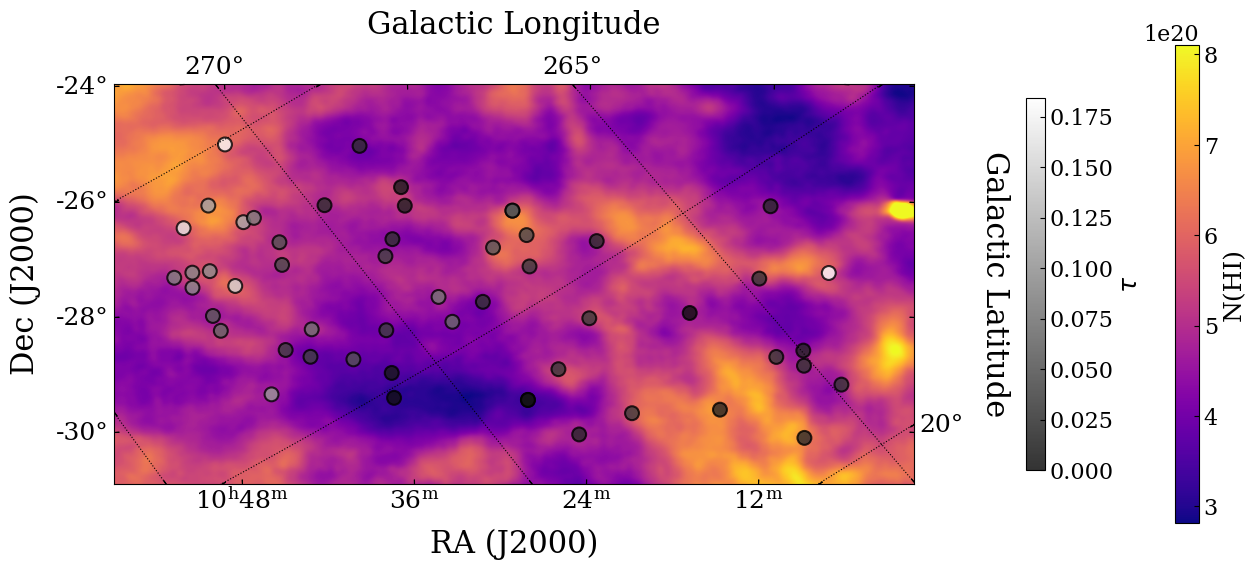

In [72]:
plot_continuum_tau(hdulist_hi_h, ra_deg_h, dec_deg_h, df_hydra['max_amp'])

#### 3D PLOT

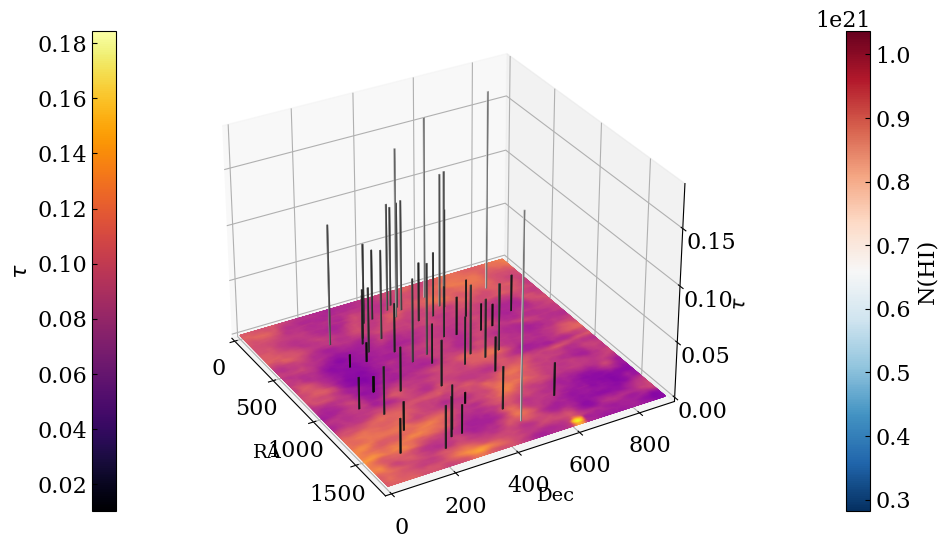

In [73]:
plot_continuum_tau_3d(hdulist_hi_h, ra_deg_h, dec_deg_h, df_hydra['max_amp'])

## Norma

In [74]:
with open('gausspyplus/ASKAP/decomposition_norma/gpy_decomposed/spectra_norma_g+_fit_fin.pickle', 'rb') as f:
    decomposition_norma = pickle.load(f)

with open('Decomposition/ASKAP/coordinates_norma.pkl', 'rb') as f:
    location_norma = pickle.load(f)

In [75]:
def get_amplitudes_norma(source):
    # Get the index_fit corresponding to the source from location_hydra
    index_fit = location_norma.get(source,{}).get('index',None)
    
    # If the index_fit exists, get the corresponding amplitudes from decomposition_hydra
    if index_fit != None:
        return decomposition_norma.get('amplitudes_fit', None)[index_fit]
    return None


In [76]:
df_norma['amplitudes_fit'] = df_norma['source'].apply(get_amplitudes_norma)

In [77]:
df_norma['max_amp'] = df_norma['amplitudes_fit'].apply(lambda x: max(x) if isinstance(x, list) and len(x) > 0 else 0)

In [78]:
ra_n = np.array(df_norma['ra (hms)'])
dec_n = np.array(df_norma['dec (dms)'])
ra_deg_n = np.array(df_norma['ra (deg)'])
dec_deg_n = np.array(df_norma['dec (deg)'])
centre_n = '16:38:00, -59:50:00'
coordinate_n = centre_n.replace(',', '')
c_n = SkyCoord(coordinate_n, unit=(u.hourangle, u.deg))
path_hi_n = SkyView.get_images(position=centre_n, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
hdulist_hi_n = path_hi_n[0]


#### 2D 

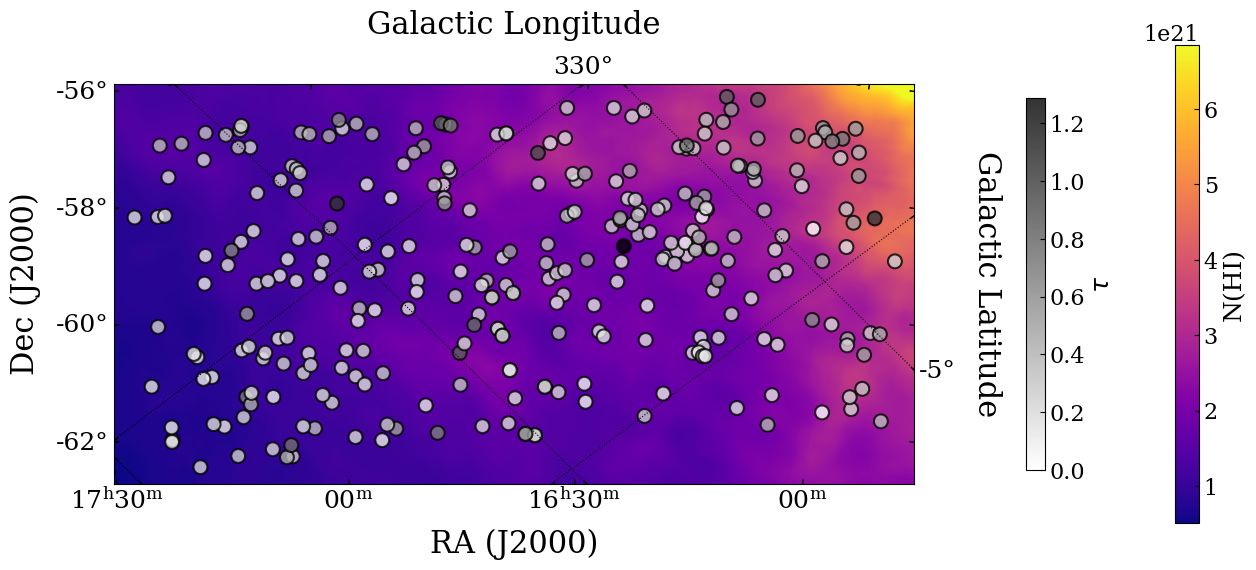

In [110]:
plot_continuum_tau(hdulist_hi_n, ra_deg_n, dec_deg_n, df_norma['max_amp'])

#### 3D

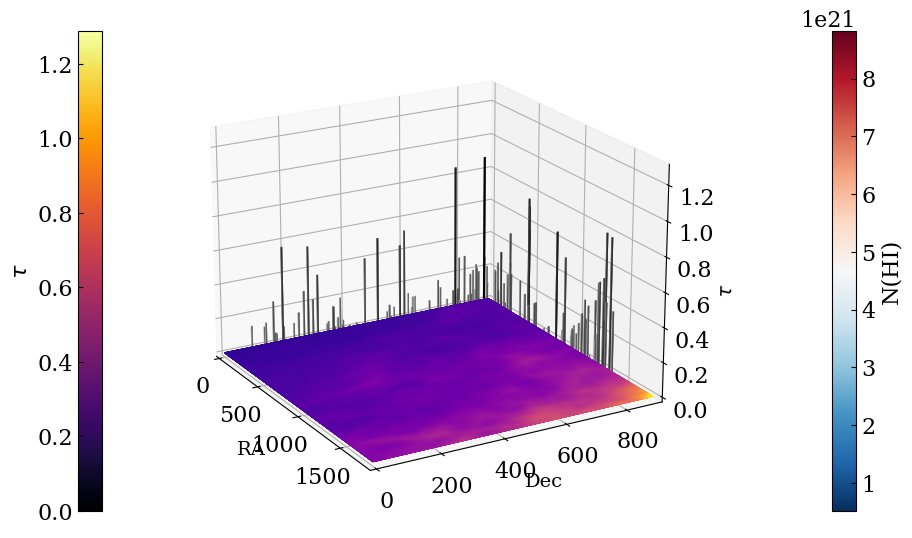

In [111]:
plot_continuum_tau_3d(hdulist_hi_n, ra_deg_n, dec_deg_n, df_norma['max_amp'], elev=20, azim=-30)

In [84]:
file_path_hydra_askap = "gausspyplus/ASKAP/decomposition_hydra/gpy_decomposed/spectra_hydra_g+_fit_fin_finalized.dat"
file_path_norma_askap = "gausspyplus/ASKAP/decomposition_norma/gpy_decomposed/spectra_norma_g+_fit_fin_finalized.dat"

In [85]:
df_hydra_askap = pd.read_csv(file_path_hydra_askap, delim_whitespace=True)
df_norma_askap = pd.read_csv(file_path_norma_askap, delim_whitespace=True)

In [91]:
df_norma_askap

,x_pos,y_pos,RA,DEC,amp,e_amp,VLSR,e_VLSR,vel_disp,e_vel_disp,...,pvalue,aicc,rchi2,ncomps,ncomp_wmedian,ncomp_jumps,flag_blended,flag_neg_res_peak,flag_broad,flag_centroid
0,0,0,1.0000,1.0000,0.0477,0.0129,1.8734,0.6378,2.8408,0.9373,...,0.2464,-521.4756,1.2618,2,2,0,0,0,0,0
1,0,0,1.0000,1.0000,0.0616,0.0043,-7.5160,1.5086,5.9844,1.0939,...,0.2464,-521.4756,1.2618,2,2,0,0,0,0,0
2,1,0,NaN,NaN,0.4190,0.2341,0.3293,0.6465,3.8897,0.4456,...,0.0193,-464.3160,2.0795,2,2,0,1,0,0,0
3,1,0,NaN,NaN,0.1040,0.1391,-5.7138,9.9108,5.3172,3.5443,...,0.0193,-464.3160,2.0795,2,2,0,1,0,0,0
4,2,0,NaN,NaN,0.6518,0.0285,4.8038,0.2229,4.4144,0.2228,...,0.0291,-327.0606,0.9931,1,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,5,16,6.0124,2.8146,0.1864,0.0045,0.4467,0.1021,3.6261,0.0995,...,0.0036,-505.9569,1.6298,1,1,0,0,0,0,0
400,6,16,NaN,NaN,0.1762,0.0055,4.0114,0.1574,4.3819,0.1572,...,0.4024,-557.2115,0.9738,1,1,0,0,0,0,0
401,7,16,NaN,NaN,0.3994,0.0281,1.8939,0.3444,4.3170,0.3448,...,0.0289,-285.5952,2.1545,1,1,0,0,0,0,0
402,8,16,NaN,NaN,0.1596,0.0300,3.1863,0.3934,3.2305,0.3717,...,0.3337,-451.0548,1.0676,2,1,0,0,0,0,0


In [89]:
df_norma

,source,ra (deg),dec (deg),ra (hms),dec (dms),amplitudes_fit,max_amp
0,165201.3-581710,253.005417,-58.286111,16:52:01.3,-58:17:10,"[0.0476959291355819, 0.06155508149694652]",0.061555
1,164533.5-570200,251.389583,-57.033333,16:45:33.5,-57:02:00,"[0.4190399608068006, 0.10403515675570346]",0.419040
2,171143.0-613251,257.929167,-61.547500,17:11:43.0,-61:32:51,[0.651834098717525],0.651834
3,162821.9-601103,247.091250,-60.184167,16:28:21.9,-60:11:03,[0.14398956816137248],0.143990
4,162641.7-584749,246.673750,-58.796944,16:26:41.7,-58:47:49,[0.2372730564541629],0.237273
...,...,...,...,...,...,...,...
292,161422.6-605801,243.594167,-60.966944,16:14:22.6,-60:58:01,"[0.12006740651435448, 0.02806884866381634, 0.1...",0.120067
293,170418.1-575103,256.075417,-57.850833,17:04:18.1,-57:51:03,[0.18638364472752653],0.186384
294,170209.9-613837,255.541250,-61.643611,17:02:09.9,-61:38:37,[0.17624404029789964],0.176244
295,162547.9-583847,246.449583,-58.646389,16:25:47.9,-58:38:47,[0.3993728876133983],0.399373


In [90]:
location_norma

{'165201.3-581710': {'pos': (0, 0), 'index': 0},
 '164533.5-570200': {'pos': (1, 0), 'index': 1},
 '171143.0-613251': {'pos': (2, 0), 'index': 2},
 '162821.9-601103': {'pos': (3, 0), 'index': 3},
 '162641.7-584749': {'pos': (4, 0), 'index': 4},
 '170919.5-623016': {'pos': (5, 0), 'index': 5},
 '164801.1-572417': {'pos': (6, 0), 'index': 6},
 '163126.6-583518': {'pos': (7, 0), 'index': 7},
 '161717.9-584807': {'pos': (8, 0), 'index': 8},
 '171226.6-615346': {'pos': (9, 0), 'index': 9},
 '164929.0-594407': {'pos': (10, 0), 'index': 10},
 '161851.5-572246': {'pos': (11, 0), 'index': 11},
 '164236.0-591134': {'pos': (12, 0), 'index': 12},
 '163405.2-590814': {'pos': (13, 0), 'index': 13},
 '163958.9-603707': {'pos': (14, 0), 'index': 14},
 '171502.1-620106': {'pos': (15, 0), 'index': 15},
 '162151.2-604517': {'pos': (16, 0), 'index': 16},
 '161051.3-575049': {'pos': (17, 0), 'index': 17},
 '164602.7-570037': {'pos': (0, 1), 'index': 18},
 '161457.9-562605': {'pos': (1, 1), 'index': 19},
 '

In [93]:
filtered_df

,x_pos,y_pos,RA,DEC,amp,e_amp,VLSR,e_VLSR,vel_disp,e_vel_disp,...,aicc,rchi2,ncomps,ncomp_wmedian,ncomp_jumps,flag_blended,flag_neg_res_peak,flag_broad,flag_centroid,source_name
14,9,0,NaN,NaN,0.2163,0.0443,528.4621,0.8246,3.4098,0.7899,...,-255.5309,2.2418,2,1,0,0,0,0,1,171226.6-615346
17,11,0,NaN,NaN,0.0734,0.0187,47.9315,1.1319,3.8363,1.1240,...,-271.0989,2.4672,2,1,0,0,0,0,0,161851.5-572246
19,12,0,NaN,NaN,0.1538,0.0236,-22.1981,1.1445,6.1521,1.2184,...,-392.6830,0.7274,2,1,0,0,0,0,0,164236.0-591134
29,2,1,NaN,NaN,0.1768,0.0313,-21.1941,0.8052,3.9529,0.8112,...,-331.9804,1.5011,2,1,0,0,0,0,1,161622.0-581136
36,7,1,NaN,NaN,0.0717,0.0034,-19.6684,0.2352,4.2810,0.2355,...,-595.3401,1.0884,2,1,0,0,0,0,0,165748.9-612138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,16,14,NaN,NaN,0.0392,0.0061,-37.7260,4.8735,23.3741,5.2436,...,-319.8682,3.5823,2,1,0,0,0,1,0,161227.6-585121
369,17,14,NaN,NaN,0.1267,0.0168,-16.3884,0.7184,4.6927,0.7231,...,-350.5119,2.7296,2,1,0,0,0,0,0,160146.9-571831
373,1,15,2.0046,5.4787,0.0417,0.0084,-137.1809,2.7402,11.7986,2.7402,...,-408.9725,1.3254,2,1,0,0,0,1,0,172157.6-620941
392,0,16,1.0000,5.7468,0.2120,0.0371,-36.2535,1.3674,6.7627,1.3674,...,-215.8877,0.8927,2,1,0,0,0,0,0,164849.9-570508


In [95]:
import pandas as pd

# Step 1: Filter df_norma_askap for VLSR > 15 or VLSR < -15
filtered_df = df_norma_askap[(df_norma_askap['VLSR'] > 15) | (df_norma_askap['VLSR'] < -15)]

def match_source_name(row, location_norma):
    # Update these to reflect the correct column names
    x_pos, y_pos = row['x_pos'], row['y_pos']
    
    # Loop through location_norma to find matching positions
    for source, info in location_norma.items():
        if info['pos'] == (x_pos, y_pos):
            return source  # Return the source name if positions match
    return None  # Return None if no match is found


# Step 3: Apply the function to get source names
filtered_df['source_name'] = filtered_df.apply(match_source_name, axis=1, location_norma=location_norma)

# Apply the function with the correct column names
df_norma['source_name'] = df_norma.apply(lambda row: match_source_name(row, location_norma), axis=1)


/tmp/ipykernel_3989/2423456002.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['source_name'] = filtered_df.apply(match_source_name, axis=1, location_norma=location_norma)


KeyError: 'x_pos'

In [108]:
df_norma.apply(lambda df_norma: print(filtered_df['x_pos']), axis=1)

14      9
17     11
19     12
29      2
36      7
       ..
368    16
369    17
373     1
392     0
397     4
Name: x_pos, Length: 64, dtype: int64
14      9
17     11
19     12
29      2
36      7
       ..
368    16
369    17
373     1
392     0
397     4
Name: x_pos, Length: 64, dtype: int64
14      9
17     11
19     12
29      2
36      7
       ..
368    16
369    17
373     1
392     0
397     4
Name: x_pos, Length: 64, dtype: int64
14      9
17     11
19     12
29      2
36      7
       ..
368    16
369    17
373     1
392     0
397     4
Name: x_pos, Length: 64, dtype: int64
14      9
17     11
19     12
29      2
36      7
       ..
368    16
369    17
373     1
392     0
397     4
Name: x_pos, Length: 64, dtype: int64
14      9
17     11
19     12
29      2
36      7
       ..
368    16
369    17
373     1
392     0
397     4
Name: x_pos, Length: 64, dtype: int64
14      9
17     11
19     12
29      2
36      7
       ..
368    16
369    17
373     1
392     0
397     4
Na

0      None
1      None
2      None
3      None
4      None
       ... 
292    None
293    None
294    None
295    None
296    None
Length: 297, dtype: object

In [107]:
for index, row in filtered_df.iterrows():
    print(row)

x_pos                              9
y_pos                              0
RA                               NaN
DEC                              NaN
amp                           0.2163
e_amp                         0.0443
VLSR                        528.4621
e_VLSR                        0.8246
vel_disp                      3.4098
e_vel_disp                    0.7899
int_tot                       1.8491
e_int_tot                     0.8942
rms                           0.0382
pvalue                        0.0065
aicc                       -255.5309
rchi2                         2.2418
ncomps                             2
ncomp_wmedian                      1
ncomp_jumps                        0
flag_blended                       0
flag_neg_res_peak                  0
flag_broad                         0
flag_centroid                      1
source_name          171226.6-615346
Name: 14, dtype: object
x_pos                             11
y_pos                              0
RA            